In [3]:
import os
import nrrd
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import shutil
from matplotlib.image import imsave
from skimage.transform import  resize

import cv2

In [4]:
excel_file_path = "/kaggle/input/lung-ds-raw/AI Project 2024-2025/dataset_lung.xlsx" 
train_folder = "/kaggle/input/lung-ds-raw/AI Project 2024-2025/Train" 

output_dir = "/kaggle/working/lung-ds"
output_folder_full_slice = os.path.join(output_dir, "Full_slice")
output_folder_nodule = os.path.join(output_dir, "Nodule")

In [5]:
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  

In [6]:
df = pd.read_excel(excel_file_path)
df['TumorClass'] = df['TumorClass'] - 1

In [18]:
def balance_classes(df, label_column):
    class_counts = df[label_column].value_counts()
    print("Original class distribution:")
    print(class_counts)

    # Determine thresholds
    max_target = int(class_counts.max())  # NO DOWNSAMPLING
    min_target = int(class_counts.max())  # Upsample minority classes to mean size

    dfs = []

    for label in df[label_column].unique():
        label_data = df[df[label_column] == label]
        current_count = len(label_data)

        if current_count > max_target:
            # Downsample majority class
            downsampled_data = resample(
                label_data,
                replace=False,  # Sample without replacement
                n_samples=max_target,
                random_state=42
            )
            dfs.append(downsampled_data)

        elif current_count < min_target:
            # Upsample minority class
            upsampled_data = resample(
                label_data,
                replace=True,  # Sample with replacement
                n_samples=min_target,
                random_state=42
            )
            dfs.append(upsampled_data)

        else:
            # Keep as is
            dfs.append(label_data)

    # Combine balanced data
    df_balanced = pd.concat(dfs)

    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Verify new distribution
    print("\nBalanced class distribution:")
    print(df_balanced[label_column].value_counts())

    return df_balanced


In [19]:
from skimage import measure, morphology, segmentation
import scipy.ndimage as ndimage

def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int64)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = segmentation.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((7,7)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))

    #### nodule
    lung_nodule_1 = np.bitwise_or(marker_internal, image)
    lung_nodule = np.where(lungfilter == 1, lung_nodule_1, np.zeros((512, 512)))
    
    return segmented


In [7]:
def gamma_transform(image, gamma):
    hu_min = np.min(image)
    hu_max = np.max(image)
    normalized_image = (image - hu_min) / (hu_max - hu_min) # Normalize to [0, 1]
    gamma_corrected  = np.power(normalized_image, gamma) # Apply gamma transformation
    # gamma_corrected = (gamma_corrected * 255).astype(np.uint8) # Scale back to the original HU range
    gamma_corrected  = gamma_corrected * (hu_max - hu_min) + hu_min # Scale back to the original HU range
    return gamma_corrected

In [8]:
def get_unique_filename(save_path):
    base, ext = os.path.splitext(save_path)
    counter = 0
    unique_path = save_path

    while os.path.exists(unique_path):
        unique_path = f"{base}_{counter}{ext}"
        counter += 1

    return unique_path

MIN_HU = -500.0
MAX_HU = 400.0
PIXEL_MEAN = 0.25 #LUNA16 competition

def normalize(data):
    normalized = (data - MIN_HU) / (MAX_HU - MIN_HU)
    normalized = normalized - PIXEL_MEAN
    normalized[normalized>1] = 1.
    normalized[normalized<0] = 0.

    return normalized
    

def convert_nrrd_to_image(nrrd_path, save_path, resize_to=None):
    data, header = nrrd.read(nrrd_path)

    
    #hu_min, hu_max = -50, 100
    
    #data_filtered = np.where(test_outline == True, 0, test_segmented)

    #data_clipped = np.where((data >= hu_min) & (data <= hu_max), data, min_v)

    #if resize_to is None:
    #    data = seperate_lungs(data)
    
    #normalized = normalize(data)

    ##rgb_image = np.stack([normalized] * 3, axis=-1)

    #if resize_to is None:
    #    rgb_image = resize(rgb_image, (224, 224), anti_aliasing=True)
    

    # Convert to grayscale and then RGB
    #grayscale_image = (normalized * 255).astype(np.uint8)
    #rgb_image = np.stack([zero_centered] * 3, axis=-1)

    #test_images.append(rgb_image)
    if resize_to is None:
        temp_slice = np.clip(data, MIN_HU, MAX_HU)
        temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        temp_slice = np.uint8(temp_slice)
        temp_slice = clahe.apply(temp_slice)
    else:
        temp_slice = np.clip(data, MIN_HU, MAX_HU)
        temp_slice = cv2.normalize(temp_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        temp_slice = gamma_transform(temp_slice, gamma=1.35)
    
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
        temp_slice = np.uint8(temp_slice)
        temp_slice = clahe.apply(temp_slice)
    
        temp_slice = cv2.resize(temp_slice, resize_to)

    rgb_image = np.stack([temp_slice] * 3, axis=-1)   
    unique_save_path = get_unique_filename(save_path)

    imsave(unique_save_path, rgb_image)


In [9]:
def create_imagefolder_dataset(df, 
                               image_column, 
                               label_column, 
                               output_folder, 
                               source_folder, 
                               resize_to=None):
    os.makedirs(output_folder, exist_ok=True)

    for label in df[label_column].unique():
        label_data = df[df[label_column] == label]

        label_folder = os.path.join(output_folder, str(label))
        os.makedirs(label_folder, exist_ok=True)

        for _, row in label_data.iterrows():
            nrrd_name = row[image_column]
            source_path = os.path.join(source_folder, nrrd_name)
            dest_path = os.path.join(label_folder, nrrd_name.replace('.nrrd', '.png'))
            convert_nrrd_to_image(source_path, dest_path, resize_to=resize_to)

    print(f"Dataset created in {output_folder} for {label_column}.")


In [10]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

#train_data_balanced = balance_classes(train_data, label_column="TumorClass")
#val_data_balanced = balance_classes(val_data, label_column="TumorClass")

create_imagefolder_dataset(
    df=train_data,
    image_column="Full_slice",
    label_column="TumorClass",
    output_folder=os.path.join(output_folder_full_slice, "train"),
    source_folder=train_folder
)

create_imagefolder_dataset(
    df=val_data,
    image_column="Full_slice",
    label_column="TumorClass",
    output_folder=os.path.join(output_folder_full_slice, "val"),
    source_folder=train_folder
)

Dataset created in /kaggle/working/lung-ds/Full_slice/train for TumorClass.
Dataset created in /kaggle/working/lung-ds/Full_slice/val for TumorClass.


In [42]:
create_imagefolder_dataset(
    df=train_data,
    image_column="Nodule",
    label_column="TumorClass",
    output_folder=os.path.join(output_folder_nodule, "train"),
    source_folder=train_folder,
    resize_to=(52,52)
)

create_imagefolder_dataset(
    df=val_data,
    image_column="Nodule",
    label_column="TumorClass",
    output_folder=os.path.join(output_folder_nodule, "val"),
    source_folder=train_folder,
    resize_to=(52,52)
)

Dataset created in /kaggle/working/lung-ds/Nodule/train for TumorClass.
Dataset created in /kaggle/working/lung-ds/Nodule/val for TumorClass.


SyntaxError: not a PNG file (<string>)

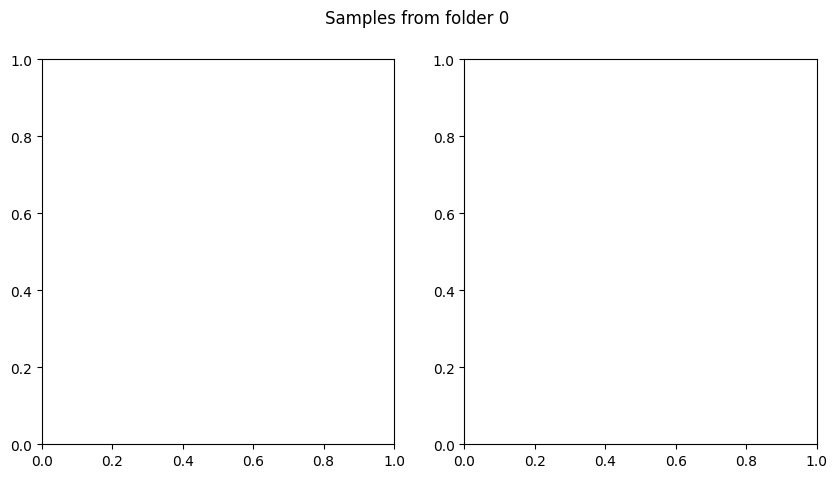

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Base path of the directories
base_path = '/kaggle/working/lung-ds/Full_slice/train/'

# Iterate through folders 0 to 4
for folder in range(5):
    folder_path = os.path.join(base_path, str(folder))
    
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        continue

    # Get all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    if len(files) < 2:
        print(f"Folder {folder_path} has less than 2 files.")
        continue

    # Randomly select 2 files
    sample_files = random.sample(files, 2)

    # Plot the samples
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Samples from folder {folder}")

    for ax, file in zip(axes, sample_files):
        file_path = os.path.join(folder_path, file)
        img = mpimg.imread(file_path)
        ax.imshow(img, cmap='gray')  # Assuming the images are grayscale
        ax.set_title(file)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [43]:
import shutil
shutil.make_archive("lung-ds", 'zip', output_dir)

'/kaggle/working/lung-ds.zip'